In [6]:
nums = (55, 44, 33, 22)
print(max(min(nums[:2]), abs(-42)))

44


In [1]:
!unzip tensortrade.zip
#!unrar x LOB1_NQU22-CME_1min_2PercentSum_100PercentOrders_Overlapped_20Jun2022_19Sep2022.rar

In [20]:
#get data from link
!wget -O data.zip https://www.dropbox.com/s/asg9ddvg46mr7iq/LOB1_NQZ22_1min_2PercentSum_100PercentOrders_Overlapped_2.zip?dl=0
!unzip  '/content/data.zip'

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unrar' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
## test if using gpu or not # tensorflow
# import tensorflow as tf
# tf.config.list_physical_devices('GPU')

In [ ]:
# test and use gpu # pytorch
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [2]:
!pip install tabulate
!pip install stable_baselines3
!pip install gym
!pip install deprecated
!pip install stockstats
!pip install zigzag
!pip install unrar
!pip install optuna

In [2]:
##################### Base Libs #####################
#from tensortrade.data.inputs import *
from tensortrade.data.feature_engineering import FeatureEngineering
import tensortrade.env.default as default
import tensortrade.env.env_stocktrading_train as Environment_Train
import tensortrade.env.env_stocktrading_test as Environment_Test
################### Others ##########################
import numpy as np
import pandas as pd
import json
import optuna
import time
import os

In [3]:
Config_Path= "configuration.json"
Config_File= open(Config_Path)
Config = json.load(Config_File)

In [4]:
'''


Data Ghathering 



'''

'\n\n\nData Ghathering \n\n\n\n'

In [5]:
# see data path
print('Data Path is :',Config['Data_Path'])

Data Path is : LOB1_NQU22-CME_1min_2PercentSum_100PercentOrders_Overlapped_20Jun2022_19Sep2022.csv


In [12]:
# Primary feature engineering and data cleaning

import shutil
import ntpath
import os
import numpy as np
import math
####################################

def k_moving_average(arr, window_size=20):
    moving_averages = []
    i = 0
    while i < len(arr) - window_size + 1:
        window_average = round(np.sum(arr[i:i+window_size]) / window_size, 2)
        moving_averages.append(window_average)
        i += 1
    return moving_averages
    
def process_data(path, ind, n, first_line, cols, dirname, level=10, k=[5,10,20,50,100], look_back=50):
    data = [first_line]
    with open(path, 'r') as f:
        for i, line in enumerate(f):
            if i >= ind[0] and i < ind[1]:
                data.append(line)
    ltps = []
    for line in data[1:]:
        splits = line.split('|')
       
        ltp = float(splits[cols['Candle_LastTradePrice']])
        ltps.append(ltp)
    multi_labels = []
    for h in k:
        ma = k_moving_average(ltps, h)
        k_minus = np.array([np.nan] * (h-1) + ma)
        k_plus = np.array(ma + [np.nan] * (h-1))
        smoothing = (k_plus - k_minus) / k_minus
        alpha = np.std(smoothing[~np.isnan(smoothing)]) / 2
        labels = []
        for s in smoothing[~np.isnan(smoothing)]:
            if s > alpha:
                labels.append(s)
            elif s < -alpha:
                labels.append(s)
            else:
                labels.append(s)
        labels_str = [np.nan] * (h-1) + labels + [np.nan] * (h-1)
        labels_str = [str(i) for i in labels_str]
        multi_labels.append(labels_str)
    data[0] = data[0][:-1] + '|Label1|Label2|Label3|Label4|Label5\n'
    for i in range(len(data)):
        if i == 0:
          continue
        else:
          splits = data[i].split('|')
          bidprices = splits[cols['LOB_BidPrices']].split(',')
          bidprices = [p for p in bidprices if p != ''][-level:]
          askprices = splits[cols['LOB_AskPrices']].split(',')
          askprices = [p for p in askprices if p != ''][:level]
          bidvolumes = splits[cols['LOB_BidVolumes']].split(',')
          bidvolumes = [v for v in bidvolumes if v != ''][-level:]
          askvolumes = splits[cols['LOB_AskVolumes']].split(',')
          askvolumes = [v for v in askvolumes if v != ''][:level]
          splits[cols['LOB_BidPrices']] = ','.join(bidprices)
          splits[cols['LOB_AskPrices']] = ','.join(askprices)
          splits[cols['LOB_BidVolumes']] = ','.join(bidvolumes)
          splits[cols['LOB_AskVolumes']] = ','.join(askvolumes)
          splits[-1] = splits[-1][:-1]
          splits.append(multi_labels[0][i-1])
          splits.append(multi_labels[1][i-1])
          splits.append(multi_labels[2][i-1])
          splits.append(multi_labels[3][i-1])
          splits.append(multi_labels[4][i-1] + '\n')
          data[i] = '|'.join(splits)
    filename = ntpath.basename(path).split('.')[0] + 'labeled{}.csv'.format(n)
    with open(os.path.join(dirname, 'labeled', filename), 'w') as f:
        for line in data:
            f.write(line)
    corrupts = []
    for i, line in enumerate(data):
        splits = line.split('|')
        bidprices = splits[cols['LOB_BidPrices']].split(',')
        askprices = splits[cols['LOB_AskPrices']].split(',')
        bidvolumes = splits[cols['LOB_BidVolumes']].split(',')
        askvolumes = splits[cols['LOB_AskVolumes']].split(',')
        if len(bidprices) < level or len(askprices) < level or '' in askprices or '' in bidprices:    # corrupt condition
            corrupts.append(i)
    print(len(corrupts))
    subfiles = []
    for i in range(len(corrupts) - 1):
        start = corrupts[i]
        end = corrupts[i+1]
        if end - start - 1 >= look_back:
            subfiles.append(data[start+1:end])
    if (len(data) - 1 - corrupts[-1]) >= look_back:
        subfiles.append(data[corrupts[-1]+1:])
    total = []
    for f in subfiles:
        total += f
    filename = ntpath.basename(path).split('.')[0] + '_clean_labeled_{}.csv'.format(n)
    with open(os.path.join(dirname, 'clean_labeled', filename), 'w') as f:
        for line in total:
            f.write(line)
    samplesX = []
    samplesY = []
    for f in subfiles:
        for i in range(look_back-1, len(f)):
            splits = f[i].split('|')
            sample_labels = [float(splits[-5])+1, float(splits[-4])+1, float(splits[-3])+1, float(splits[-2])+1, float(splits[-1][:-1])+1]
            if any([math.isnan(i) for i in sample_labels]):
                continue
            total_ask_prices = []
            total_ask_volumes = []
            total_bid_prices = []
            total_bid_volumes = []
            for j in range(i+1-look_back, i+1):
                spltis = f[j].split('|')
                total_ask_prices = total_ask_prices + splits[cols['LOB_AskPrices']].split(',')
                total_bid_prices = total_bid_prices + splits[cols['LOB_BidPrices']].split(',')
                if '' in total_bid_prices:
                    print(splits[cols['LOB_BidPrices']])
                    return splits[cols['LOB_BidPrices']]
                total_ask_volumes = total_ask_volumes + splits[cols['LOB_AskVolumes']].split(',')
                total_bid_volumes = total_bid_volumes + splits[cols['LOB_BidVolumes']].split(',')
            total_ask_prices = np.array([float(i) for i in total_ask_prices])
            total_ask_volumes = np.array([float(i) for i in total_ask_volumes])
            total_bid_prices = np.array([float(i) for i in total_bid_prices])
            total_bid_volumes = np.array([float(i) for i in total_bid_volumes])
            price_mean = np.concatenate([total_ask_prices, total_bid_prices]).mean()
            price_std = np.concatenate([total_ask_prices, total_bid_prices]).std()
            volume_mean = np.concatenate([total_ask_volumes, total_bid_volumes]).mean()
            volume_std = np.concatenate([total_ask_volumes, total_bid_volumes]).std()
            total_ask_prices = (total_ask_prices - price_mean) / price_std
            total_ask_volumes = (total_ask_volumes - volume_mean) / volume_std
            total_bid_prices = (total_bid_prices - price_mean) / price_std
            total_bid_volumes = (total_bid_volumes - volume_mean) / volume_std
            total = np.stack([total_ask_prices, total_bid_prices, total_ask_volumes, total_bid_volumes]).T
            total = total.reshape((look_back, -1))
            samplesX.append(total)
           
            samplesY.append(sample_labels)
    X_name = ntpath.basename(path).split('.')[0] + 'X{}.npy'.format(n)
    y_name = ntpath.basename(path).split('.')[0] + 'y{}.npy'.format(n)
    with open(os.path.join(dirname, 'numpy', X_name), 'wb') as f:
        np.save(f, np.array(samplesX).reshape(-1, look_back, level*4, 1))
    with open(os.path.join(dirname, 'numpy', y_name), 'wb') as f:
        np.save(f, np.array(samplesY))

def prepare_data_2(path, level=10, k=[5,10,20,50,100], look_back=50):
    dirname = ntpath.basename(path).split('.')[0] + '_processed'
    count = 0
    with open(path, 'r') as f:
        for line in f:
            if count == 0:
                cols = line.split('|')
                cols[-1] = cols[-1][:-1]
                cols = {cols[i]:i for i in range(len(cols))}
                first_line = line
            count += 1
   
    n = (count // 21541) + 1
    
    inds = []
    for i in range(n):
        if (count - i*21541) > 21541:
            if i == 0:
                inds.append((1, (i+1)*21541))
            else:
                inds.append((i*21541, (i+1)*21541))
        else:
            inds.append((i*21541, count))
    try:
        shutil.rmtree(dirname)
        print('Removing old directory and creating a new one')
    except:
        print('No such directory')
        print('Creating new directory')
        
    os.mkdir(dirname)
    os.mkdir(os.path.join(dirname, 'labeled'))
    os.mkdir(os.path.join(dirname, 'clean_labeled'))
    os.mkdir(os.path.join(dirname, 'numpy'))

    for i, ind in enumerate(inds):
        process_data(path=path, ind=ind, n=i, first_line=first_line, cols=cols, dirname=dirname, level=level, k=k, look_back=look_back)

#######################################################

In [13]:
prepare_data_2(Config['Data_Resized_Path'])

Removing old directory and creating a new one
1


C:\Users\kasra\AppData\Local\Temp\ipykernel_22552\4278059449.py:133: RuntimeWarning: invalid value encountered in divide
  total_ask_volumes = (total_ask_volumes - volume_mean) / volume_std
C:\Users\kasra\AppData\Local\Temp\ipykernel_22552\4278059449.py:135: RuntimeWarning: invalid value encountered in divide
  total_bid_volumes = (total_bid_volumes - volume_mean) / volume_std


1
1


c:\Users\kasra\.conda\envs\Ai\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\kasra\.conda\envs\Ai\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\kasra\.conda\envs\Ai\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
column_name= ['DateTime','open', 'high', 'low',
       'close', 'Candle_LastTradePrice', 'volume',
       'bid_volume', 'ask_volume',
       'numTrades', 'bid_number',
       'ask_number', 'askbidDiffHigh',
       'askbidDifflow', 'askbidnumTradesDiffHigh',
       'askbidnumTradesDifflow', 'UpDownvolDiffHigh',
       'UpDownvolDifflow', 'ATR', 'sum_lob_bid', 'sum_lob_ask',
       'LOB_SumBidTick', 'LOB_SumAskTick', 'lob_bid_price', 'lob_bid_volume',
       'lob_ask_price', 'lob_ask_volume', 'VAP_Prices', 'VAP_Volumes',
       'VAP_AskVolumes', 'VAP_BidVolumes', 'VAP_NumberOfTrades',
       'VAP_TotalVolume']

In [16]:
# gather together cleaned datas
D1=pd.read_csv('LOB1_NQZ22_1min_2PercentSum_100PercentOrders_Overlapped_2_processed/clean_labeled/LOB1_NQZ22_1min_2PercentSum_100PercentOrders_Overlapped_2_clean_labeled_0.csv',names= column_name, usecols = [i for i in range(33)], delimiter="|")
D2=pd.read_csv('LOB1_NQZ22_1min_2PercentSum_100PercentOrders_Overlapped_2_processed/clean_labeled/LOB1_NQZ22_1min_2PercentSum_100PercentOrders_Overlapped_2_clean_labeled_1.csv',names= column_name, usecols = [i for i in range(33)], delimiter="|")
D3=pd.read_csv('LOB1_NQZ22_1min_2PercentSum_100PercentOrders_Overlapped_2_processed/clean_labeled/LOB1_NQZ22_1min_2PercentSum_100PercentOrders_Overlapped_2_clean_labeled_2.csv',names= column_name, usecols = [i for i in range(33)], delimiter="|")

FileNotFoundError: [Errno 2] No such file or directory: 'LOB1_NQU22-LOB1_NQZ22_1min_2PercentSum_100PercentOrders_Overlapped_2_processed/clean_labeled/LOB1_NQZ22_1min_2PercentSum_100PercentOrders_Overlapped_2_clean_labeled_0.csv'

In [7]:
Data= pd.concat([D1,D2,D3])
Data["DateTime"] = pd.to_datetime(Data["DateTime"])
Data.set_index(["DateTime"], inplace=True)

In [8]:
Data.head(3)

,open,high,low,close,Candle_LastTradePrice,volume,bid_volume,ask_volume,numTrades,bid_number,...,lob_bid_price,lob_bid_volume,lob_ask_price,lob_ask_volume,VAP_Prices,VAP_Volumes,VAP_AskVolumes,VAP_BidVolumes,VAP_NumberOfTrades,VAP_TotalVolume
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-06-19 23:59:00,11385.5,11385.50,11378.00,11379.25,11378.50,129,66,63,123,66,...,"11383.00,11383.25,11383.50,11383.75,11384.00,1...","1,2,1,1,1,2,2,1,1,1","11378.25,11378.50,11378.75,11379.00,11379.25,1...","2,1,1,1,2,1,2,2,2,1","11378.00,11378.25,11378.50,11378.75,11379.00,1...","3,3,12,32,15,17,14,5,8,1,2,2,1,2,1,2,1,4,1,1,1,1,","0,0,3,20,9,11,8,2,7,1,0,0,0,0,0,0,0,2,0,0,0,0,","3,3,9,12,6,6,6,3,1,0,2,2,1,2,1,2,1,2,1,1,1,1,","3,3,12,29,14,17,14,5,6,1,2,2,1,2,1,2,1,4,1,1,1,1,",129
2022-06-20 00:00:00,11378.5,11387.25,11369.50,11381.25,11382.00,343,171,172,327,170,...,"11384.50,11384.75,11385.00,11385.25,11385.50,1...","2,1,1,1,1,2,2,3,2,1","11370.00,11370.25,11370.50,11370.75,11371.00,1...","1,1,2,2,2,1,1,2,1,1","11369.50,11369.75,11370.00,11370.25,11370.50,1...","1,1,4,1,1,5,1,1,2,1,10,6,7,3,13,2,2,3,2,2,3,2,...","0,0,1,1,1,1,0,0,1,1,0,3,3,0,10,1,1,2,2,1,1,2,2...","1,1,3,0,0,4,1,1,1,0,10,3,4,3,3,1,1,1,0,1,2,0,2...","1,1,4,1,1,5,1,1,2,1,10,6,7,3,10,2,2,3,2,2,3,2,...",343
2022-06-20 00:01:00,11382.0,11397.25,11379.75,11395.50,11397.25,282,84,198,255,83,...,"11394.25,11394.50,11394.75,11395.00,11395.25,1...","4,4,3,1,1,3,4,3,1,2","11380.25,11380.50,11380.75,11381.00,11381.25,1...","1,1,14,1,1,1,1,1,1,1","11379.75,11380.25,11380.50,11380.75,11381.00,1...","1,4,3,26,2,4,1,2,7,3,3,2,3,4,3,7,3,4,9,4,3,2,2...","0,0,1,25,0,4,0,0,4,0,2,1,2,0,0,5,2,0,9,2,2,1,1...","1,4,2,1,2,0,1,2,3,3,1,1,1,4,3,2,1,4,0,2,1,1,1,...","1,4,3,8,2,4,1,2,7,3,3,2,3,3,3,7,3,4,9,4,3,2,2,...",282


In [9]:
'''


Train Test and Optimize



'''

'\n\n\nTrain Test and Optimize\n\n\n\n'

In [11]:
# func to create environment

def create_env_train(data,price,date,config):

    env= Environment_Train.StockTradingEnv_Train(data,price,date,config)
    
    return env

In [12]:
# func to create test environment

def create_env_test(data,price,date,config):

    env= Environment_Test.StockTradingEnv_Test(data,price,date,config)

    return env

In [13]:
# import RL agents
from stable_baselines3 import A2C,DQN,PPO
# import environment checker
from stable_baselines3.common import env_checker

In [14]:
# # check if environment meet gym policy
# env_checker.check_env(env_train , warn=False, skip_render_check=True)

In [15]:
# import torch.nn.functional as F
# from torch.utils import data
# from torchinfo import summary
# from typing import Callable, Dict, List, Optional, Tuple, Type, Union
# from stable_baselines3.common.policies import ActorCriticPolicy

In [16]:
# make neural net for RL model
import gym
import torch
import torch as th
import torch.nn as nn
#from torch import nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int ):
     
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,4), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,4), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,10)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
             nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        # Compute shape by doing one forward pass
        # with th.no_grad():
        #     n_flatten = self.inp3(
        #         th.as_tensor(observation_space.sample()[None]).float()
        #     ).shape[1]
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, features_dim)

    def forward(self, x: th.Tensor) -> th.Tensor:
        
        # return self.linear(self.lstm(self.cnn(observations)))
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)
       
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)  
        
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        # forecast_y = torch.softmax(x, dim=1)
        return x

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=49),
    net_arch=[dict(vf=[64], pi=[64])]
)

In [17]:
def Main(config, trial=None):
   
    if config['RUNNING_MODE'] == 'optimize':
        config = select_params_value(trial, config)

    # Data Feature Engineering
    preProcessedData = FeatureEngineering(Data,config['Feature_engineering'])
    LOB_Data_train,LOB_Data_test,LOB_Data_train_unnormal,LOB_Data_test_unnormal,LOB_Train_dates,LOB_Test_dates = preProcessedData.add_all_features()

    # make train data
    Time_Data = LOB_Train_dates # just time column
    Data_Train=LOB_Data_train
    Price_Data = pd.DataFrame(LOB_Data_train_unnormal[['open','high','low','close']]) # just price related columns

    # make test data
    Data_Test=LOB_Data_test
    Price_Data_Test = pd.DataFrame(LOB_Data_test_unnormal[['open','high','low','close']]) # just price related columns
    #Price_Data_Test.reset_index(drop=True,inplace=True)
    Time_Data_Test = LOB_Test_dates  # just time column

    # Number of objectives
    obj_no = config['number_of_objectives']

    # create train env
    global env_train
    env_train= create_env_train(Data_Train.copy(),Price_Data.copy(),Time_Data,config['env_config_train'])

    # create test env
    global env_test
    env_test =  create_env_test(Data_Test.copy(),Price_Data_Test.copy(),Time_Data_Test,config['env_config_test'])

    # create RL model
    #policy_kwargs = dict(net_arch=[8,16, dict(vf=[32,64,128,256], pi=[32,64,128,256])])
    global RL_model
    RL_model = A2C(config['A2C_PARAMS']['net_arch'], env_train, verbose=1,device=device,
    learning_rate=config['A2C_PARAMS']['learning_rate'], policy_kwargs=policy_kwargs,seed=config['A2C_PARAMS']['SEED'])
    RL_model.learn(total_timesteps=config['A2C_PARAMS']['TOTAL_TIMESTEPS'])

    if config['RUNNING_MODE'] == 'optimize':
        RL_model.save(f"RlSurf-A2C-{trial.number}")

    # test RL model on test data
    obs = env_test.get_state()    #~ we should not reset env manullay
    number_candle=0 

    while True: 
    
        action, _states = RL_model.predict(obs,deterministic=True)
    
        number_candle+=1
        obs, rewards, done, info = env_test.step(action)

        if done:

            if env_test.day_index>= len(env_test.day_indices)-1:
                    print("Account Balance Is : ", info['account_status'])
                    
                    break
            else:
                print('episode(Day) is : ',env_test.episode)
                env_test.reset()

    if config['RUNNING_MODE'] in ('backtest','train') :
            (env_test.tradeslist).to_csv('results/TradeList.csv',sep=',')
            env_test.show_results()

    elif Config['RUNNING_MODE'] == 'optimize':
            prom,profactor= env_test.show_results()
            if obj_no == 1:
                return prom
            elif obj_no == 2:
                return prom, profactor

############## change config for each trial               
def select_params_value(trial, config):
    
    optimization_params = json.load(open('optimization_params.json'))
    for key, value in optimization_params.items():
        if key.startswith('_'):
            continue
      
        param_value = getattr(trial, value[0])(key, **value[1])

        if key in config['A2C_PARAMS'].keys():
            config['A2C_PARAMS'][key] = param_value

        elif key in config['env_config_train'].keys():
            config['env_config_train'][key] = param_value

        elif key in config['env_config_test'].keys():
            config['env_config_test'][key] = param_value
        
        elif key in config['Feature_engineering'].keys():
            config['Feature_engineering'][key] = param_value

        else:
            raise Exception('Undefined parameter ' + key)
            
    return config

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 33       |
|    iterations         | 100      |
|    time_elapsed       | 15       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.06    |
|    explained_variance | -2.42    |
|    learning_rate      | 0.0009   |
|    n_updates          | 99       |
|    policy_loss        | 0.0334   |
|    value_loss         | 0.0998   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 34       |
|    iterations         | 200      |
|    time_elapsed       | 28       |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.794   |
|    explained_variance | 0.832    |
|    learning_rate      | 0.0009   |
|    n_updates    

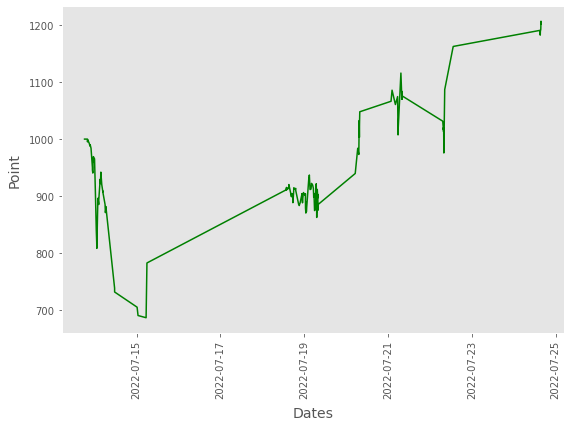

Runtime: 260 secs


In [21]:
# start time
start = time.time()
# check run mode and make study with optuna
if Config['RUNNING_MODE'] == 'optimize':
    
    study_name = Config['study_name']
    storage = 'sqlite:///optimization_results.sqlite'
    try:
        obj_no = Config['number_of_objectives']
        directions = ["maximize","maximize"] 

        if obj_no == 1:
            study = optuna.create_study(direction="maximize", study_name=study_name, storage=storage)
        else:
            study = optuna.create_study(directions=directions , study_name=study_name, storage=storage)
    except:
        study = optuna.load_study(study_name=study_name, storage=storage)
        print('- - - - - - Optimization study loaded - - - - - -')
    study.optimize(
        lambda trial: Main(Config, trial), n_trials=3, n_jobs=1, timeout=None)
        
else:
    
    try:
        os.mkdir('/results')
    except:
        pass
    Main(Config)

# total elapsed time
print(f'Runtime: {round(time.time() - start)} secs')

In [17]:
################################
################################

In [ ]:
# Data Feature Engineering
preProcessedData = FeatureEngineering(Data,Config['Feature_engineering'])
LOB_Data_test,LOB_Data_test_unnormal,LOB_Test_dates = preProcessedData.add_all_features()
# make test data
Data_Test=LOB_Data_test
Price_Data_Test = pd.DataFrame(LOB_Data_test_unnormal[['open','high','low','close']]) # just price related columns
#Price_Data_Test.reset_index(drop=True,inplace=True)
Time_Data_Test = LOB_Test_dates  # just time column
# create test env
global env_test
env_test =  create_env_test(Data_Test.copy(),Price_Data_Test.copy(),Time_Data_Test,Config['env_config_test'])

In [ ]:
RL_model = A2C.load('RlSurf-A2C')

In [ ]:
# test RL model on test data
obs = env_test.get_state()    #~ we should not reset env manullay
number_candle=0 

while True: 

    action, _states = RL_model.predict(obs,deterministic=True)

    number_candle+=1
    obs, rewards, done, info = env_test.step(action)

    if done:

        if env_test.day_index>= len(env_test.day_indices)-1:
                print("Account Balance Is : ", info['account_status'])
                
                break
        else:
            print('episode(Day) is : ',env_test.episode)
            env_test.reset()